# Fitting Tyre Deg Curves & Estimating Fuel Effect - Austria GP 2019

This notebook summarises a simple example of how we can use historical F1 Grand Prix data to fit a mathematical model that best describes tyre deg & fuel effects on lap time.

All the historical race timing data has been sourced from the (publically available) Ergast API, available at http://ergast.com/mrd/. Please refer to the *README* file in the *download* folder of the Git repository for the relevant code that gets this data from the Ergast API, and stores it in BigQuery. The rest of this notebook assumes that these datasets have already been created within BigQuery, using the naming convention mentioned in that *README* document.

**Please note: in reality, you would gather data from testing and/or practice sessions to then forecast the tyre deg for the race, rather than using race data itself as we are doing here. However, given only historical race lap times are available from the Ergast API, we will use that to illustrate the general method.**

In [1]:
import Modelling_Utilities as mu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Choose a Grand Prix & visually inspect the race lap times

In this example, we will use the 2019 Austrian Grand Prix.

In [2]:
year = 2019
round_num = 9

In [3]:
results_df = mu.download_laptimes(year, round_num)
print(results_df.columns)

Index(['year', 'round', 'raceName', 'circuitName', 'driver_name',
       'constructor_name', 'best_qual_time', 'best_qual_time_adjusted',
       'best_qual_time_adjusted_flag', 'lap_number', 'perc_race_completed',
       'race_position', 'lap_time', 'pitstop_number_inlap',
       'pitstop_number_outlap', 'circuit_tyre_stress_rating',
       'circuit_asphalt_abrasion_rating', 'circuit_asphalt_grip_rating',
       'circuit_downforce_rating', 'circuit_lateral_rating',
       'tyre_stint_number', 'tyre', 'tyre_description', 'tyre_status',
       'tyre_age_laps', 'upload_timestamp'],
      dtype='object')


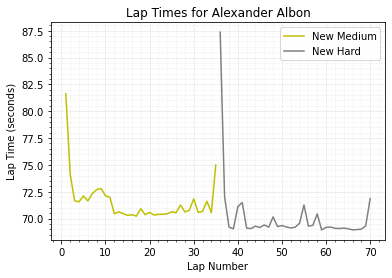

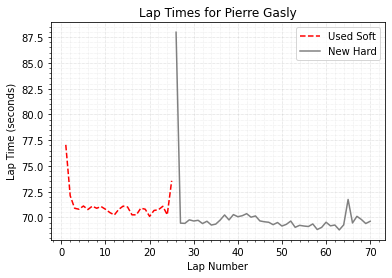

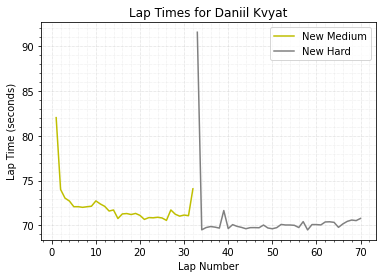

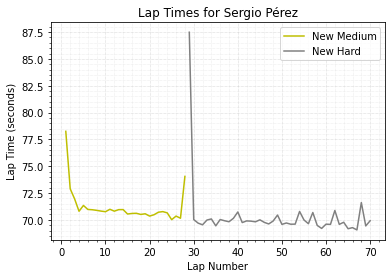

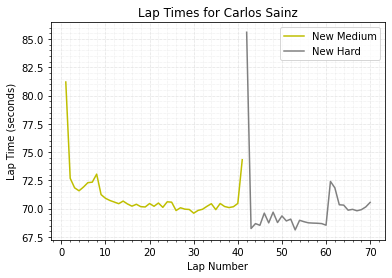

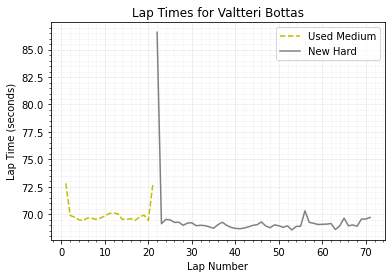

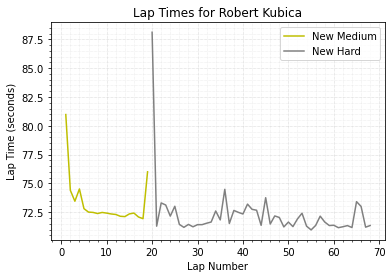

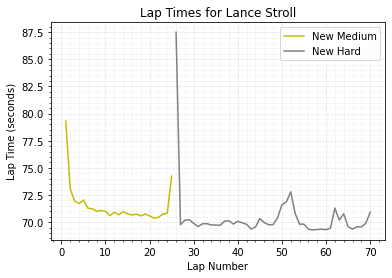

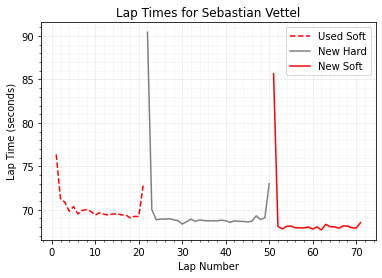

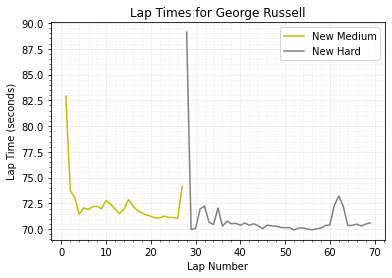

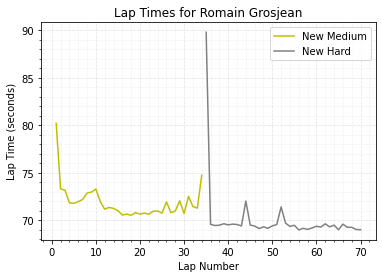

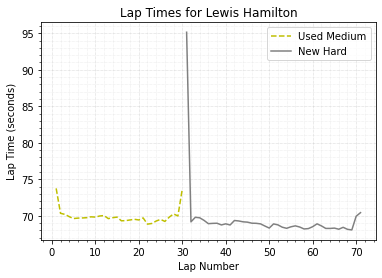

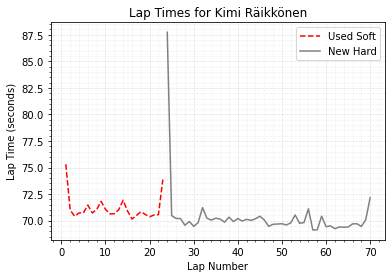

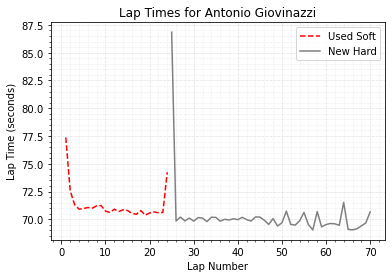

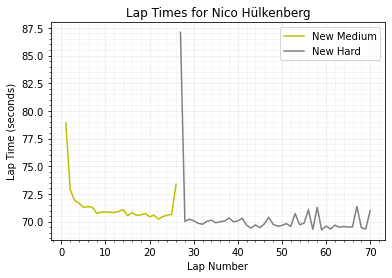

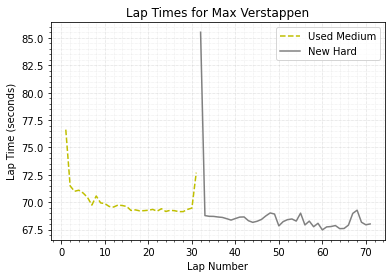

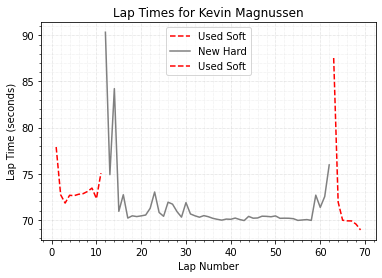

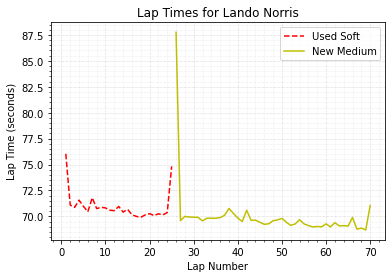

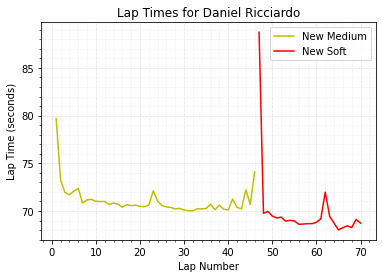

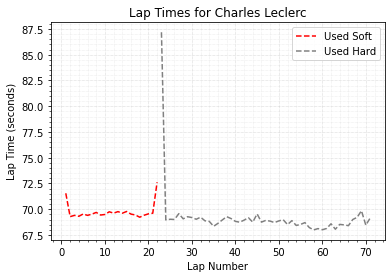

In [4]:
drivers_unique = list(dict.fromkeys(list(results_df['driver_name']))) # Removes duplicates
for d in drivers_unique:
    driver_df = results_df[results_df['driver_name'] == d]
    mu.plot_laptimes(driver_df, title = "Lap Times for {0}".format(d))

## 2. Formulate an initial idea for a model

For our first model we will assume the following relationship between lap time and other variables, for each driver:

$$l = \sum_{i=1}^{i=3} (\alpha_i t_i^2 + \beta_i)1_{i} + \gamma n + \delta q + \zeta_{in} p_{in} + \zeta_{out} p_{out} + \epsilon \,$$

where:
- $l$ is the vector of lap times for the full race
- $t_i$ are the vectors of the age of each type of tyre on each lap; here the subscript $i = 1, 2, 3$ represents soft, medium and hard tyres respectively, and the entries are zero where the respective tyre isn't being used on that lap
- $1_{i}$ are the indicator vectors of having soft, medium and hard tyres on, for $i = 1, 2, 3$ respectively (that is, their entries are 1 if the lap was done using that tyre, and 0 otherwise)
- $n$ is the vector consisting of number of laps to go, with the last lap set at zero
- $q$ is the best qualifying time of the driver, repeated across all entries of the vector
- $p_{in}$ is the vector of 1s and 0s, with a 1 where (and only where) that lap ended with a pitstop
- $p_{out}$ is the vector of 1s and 0s, with a 1 where (and only where) that lap started with a pitstop
- $\alpha_i$, $\beta_i$, $\gamma$, $\delta$, $\zeta_{in}$ and $\zeta_{out}$ are all parameters to be chosen by the model to mimimise the RMSE (root mean square error)
- $\beta_1$ is the zero vector (and so will not be fed into our linear model when we fit it later)
- $\epsilon$ is a randomly generated vector, normally distributed with zero mean

To give some intuition as to why we are using this model:
- We assume that lap times drop off quadratically from tyre deg, and that the different tyre types vary in their tyre deg characteristics
- The parameter $\gamma$ will capture the effect of using up fuel on lap time, which should turn out to be postive. We assume here that there is a linear relationship, i.e. that there is a constant lap time gain per lap, assuming the driver was to use the same amount of fuel on each lap.
- The parameter $\delta$ will relate the raw peak race performance against the best qualifying time of that driver as a percentage, to account for variances in vehicle and driver performance. Since we have forced $\beta_1$ to be zero, this $\delta$ parameter in effect measures the lap 1 performance of a fresh soft tyre in the race, vs the 1 lap performance of the same tyre in qualifying. For example, due to the fact that drivers will generally not push their car to the limit in the race, as they try to conserve tyre life.
- The parameters $\zeta_{in}$ and $\zeta_{out}$ will represent the additional lap time required for an in-lap to the pits and out-lap from the pits, respectively

It should be noted here that all the greek letter parameters will vary, certainly from circuit to circuit, but also between teams and drivers. As we only have race data available here (no practice times), we have limited data to train on and so for simplicity we will assume that the parameters are the same for every driver, to give us a basic model for now.

## 3. Clean and prepare the data for modelling

As per the proposed model above, we will define the features that will go into the model.

Firstly, from visual inspection of the charts in section 1 above, there are some clear outliers that we should remove from our data, as those laps were affected by factors outside of our model:
- Laps 1-12 for Alex Albon, Daniil Kvyat, Carlos Sainz and Romain Grosjean were (roughly) all affected by being stuck behind slower drivers
- Laps 61 onwards for Carlos Sainz were much slower than he would otherwise achieve (again presumably stuck behind a slower car)
- On laps 13, 14, 59 and 60 Kevin Magnussen slowed down considerably (again either stuck behind a slower car, or letting the leaders lap him)
- Lap 23 and 62 were also anomalies for Daniel Ricciardo
- Laps 48-54 & 61-65 were anomalies for Lance Stroll
- Laps 61-63 were anomalies for George Russell
- Lap 1 is an anomaly for all drivers as they fight for position and start from the grid

In [5]:
tyre_ages = results_df['tyre_age_laps'].to_numpy()
tyre_descriptions = results_df['tyre_description'].to_numpy()
lap_numbers = results_df['lap_number'].to_numpy()
drivers = results_df['driver_name'].to_numpy()
pitstops_in = np.nan_to_num(results_df['pitstop_number_inlap'].to_numpy())
pitstops_out = np.nan_to_num(results_df['pitstop_number_outlap'].to_numpy())
qualifying_times = results_df['best_qual_time_adjusted'].to_numpy()

Note here that the qualifying lap times are labelled as 'adjusted' - that is because in some rounds a driver may set no qualifying lap time. In this case, their qualifying time has been extrapolated using the median percentage difference between the best qualifying time in each 2019 race and that driver's best qualifying time. The 'best_qual_time_adjusted_flag' field in the dataset is 1 if this adjustment has been made, and 0 otherwise.\
Of course, in reality particularly in the early races of the year we wouldn't have this information. We would need to make an educated assumption on it, or alternatively remove that driver from the model. For this particular example of the Austrian GP, there were no such instances and so the best qualifying lap times are in fact exact:

In [6]:
bqtaf = results_df['best_qual_time_adjusted_flag'].to_numpy()
len(bqtaf[bqtaf == 1])

0

We're now going to define a 'mask' *msk* of boolean values which will allow us to remove the outliers as identified earlier from our dataset.

In [10]:
cond1 = (lap_numbers >= 1) & (lap_numbers <= 12) & ((drivers == 'Alexander Albon') | (drivers == 'Daniil Kvyat') | (drivers == 'Carlos Sainz') | (drivers == 'Romain Grosjean'))
cond2 = (lap_numbers >= 61) & (drivers == 'Carlos Sainz')
cond3 = (lap_numbers >= 13) & (lap_numbers <= 14) & (drivers == 'Kevin Magnussen')
cond4 = (lap_numbers >= 59) & (lap_numbers <= 60) & (drivers == 'Kevin Magnussen')
cond5 = ((lap_numbers == 23) | (lap_numbers == 62)) & (drivers == 'Daniel Ricciardo')
cond6 = (lap_numbers >= 48) & (lap_numbers <= 54) & (drivers == 'Lance Stroll')
cond7 = (lap_numbers >= 61) & (lap_numbers <= 65) & (drivers == 'Lance Stroll')
cond8 = (lap_numbers >= 61) & (lap_numbers <= 63) & (drivers == 'George Russell')
cond9 = (lap_numbers == 1)
msk = ~(cond1 | cond2 | cond3 | cond4 | cond5 | cond6 | cond7 | cond8 | cond9)

In [11]:
is_soft = 1*(tyre_descriptions == 'Soft')[msk]
t_1 = tyre_ages[msk] * is_soft
is_medium = 1*(tyre_descriptions == 'Medium')[msk]
t_2 = tyre_ages[msk] * is_medium
is_hard = 1*(tyre_descriptions == 'Hard')[msk]
t_3 = tyre_ages[msk] * is_hard
n = (max(lap_numbers) - lap_numbers)[msk]
q = qualifying_times[msk]
p_in = (1*(pitstops_in >= 1))[msk]
p_out = (1*(pitstops_out >= 1))[msk]

Finally, we will define the labels vector y and features matrix X, with which we will fit the model.

In [12]:
y = results_df['lap_time'].to_numpy()[msk]
X = np.c_[t_1**2, t_2**2, is_medium, t_3**2, is_hard, n, q, p_in, p_out]

In [13]:
print(y.shape)
print(X.shape)

(1306,)
(1306, 9)


## 4. Fit the model

We will now use a linear regression model to fit the data. The model has no intercept, as per the model chosen in section (2.), to allow for interpretation of each of the model coefficients.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model_quadratic = LinearRegression(fit_intercept = False)

In [15]:
model_quadratic.fit(X, y)
print(model_quadratic.coef_)
print(model_quadratic.intercept_)

[-1.13516729e-04  7.07510424e-04 -5.41543695e-01  9.35250449e-04
 -2.73190208e-01  4.69833326e-02  1.06200742e+00  3.65525892e+00
  1.82940644e+01]
0.0


In [16]:
print('Let t be the age of a tyre')
print('The soft tyre degrades as {:.4g}*t^2'.format(model_quadratic.coef_[0]))
print('The medium tyre degrades as {:.4g}*t^2 and is {:.4g} secs/lap slower than the soft tyre excl deg'.format(model_quadratic.coef_[1],model_quadratic.coef_[2]))
print('The hard tyre degrades as {:.4g}*t^2 and is {:.4g} secs/lap slower than the soft tyre excl deg'.format(model_quadratic.coef_[3],model_quadratic.coef_[4]))
print('Each lap of fuel is worth {:.4g} seconds of lap time'.format(model_quadratic.coef_[5]))
print('Race laps are around {:.4g}% slower than qualifying laps'.format(model_quadratic.coef_[6]*100 - 100))
print('An in-lap to the pits costs {:.4g} seconds of lap time'.format(model_quadratic.coef_[7]))
print('An out-lap from the pits costs {:.4g} seconds of lap time'.format(model_quadratic.coef_[8]))
print('The total time loss from a pitstop is {:.4g} seconds'.format(model_quadratic.coef_[7] + model_quadratic.coef_[8]))

Let t be the age of a tyre
The soft tyre degrades as -0.0001135*t^2
The medium tyre degrades as 0.0007075*t^2 and is -0.5415 secs/lap slower than the soft tyre excl deg
The hard tyre degrades as 0.0009353*t^2 and is -0.2732 secs/lap slower than the soft tyre excl deg
Each lap of fuel is worth 0.04698 seconds of lap time
Race laps are around 6.201% slower than qualifying laps
An in-lap to the pits costs 3.655 seconds of lap time
An out-lap from the pits costs 18.29 seconds of lap time
The total time loss from a pitstop is 21.95 seconds


## 5. Validate the model

The next piece of code evaluates the summary statistics for the model.

In [17]:
from scipy import stats
params = model_quadratic.coef_
predictions = model_quadratic.predict(X)

newX = X
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p values"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  p values
0       -0.0001            0.000    -0.353     0.724
1        0.0007            0.000     7.464     0.000
2       -0.5415            0.088    -6.159     0.000
3        0.0009            0.000    17.471     0.000
4       -0.2732            0.084    -3.262     0.001
5        0.0470            0.002    27.292     0.000
6        1.0620            0.002   609.095     0.000
7        3.6553            0.153    23.885     0.000
8       18.2941            0.148   123.237     0.000


We see here that the greatest uncertainty comes from the soft tyre deg coefficient (row 0). This makes sense, as the model is predicting a negative quadratic curve, i.e. reverse tyre wear, which seems unreasonable. It's likely that drivers on the soft tyre are trying to drive much more conservatively to preserve tyre life, which skews our understanding of tyre deg.

Generally outside of that, the results look somewhat promising as a first attempt, with the t-values and p-values indicating that each feature is important to the model fit.

## 6. Visualise the results

The code below plots each of the expected lap times from each of the three tyre compounds, based off the model that we have fitted and validated.

In [18]:
def plot_tyre_deg_curves(num_laps_plot, qual_time_plot, remove_fuel_effect, model, omega = 2):
    '''
    :param num_laps_plot: Positive integer; the number of laps to plot
    :param qual_time_plot: Positive float; the best qualifying time on the soft tyre
    :param remove_fuel_effect: Boolean; set to be True if you want to just plot tyre deg effect
    :param model: Linear regression model object that has been fitted
    :param omega: Positive float at least 1; the power of tyre age to fit in the model
    '''
    tyre_age_plot = np.linspace(0, num_laps_plot, num_laps_plot)
    
    soft_plot_X = np.c_[tyre_age_plot**omega,
                        np.zeros(num_laps_plot), np.zeros(num_laps_plot),
                        np.zeros(num_laps_plot), np.zeros(num_laps_plot),
                        (1 - remove_fuel_effect)*(max(tyre_age_plot) - tyre_age_plot),
                        qual_time_plot*np.ones(num_laps_plot),
                        np.zeros(num_laps_plot), np.zeros(num_laps_plot)]
    soft_plot_y = model.predict(soft_plot_X)

    medium_plot_X = np.c_[np.zeros(num_laps_plot),
                          tyre_age_plot**omega, np.ones(num_laps_plot),
                          np.zeros(num_laps_plot), np.zeros(num_laps_plot),
                          (1 - remove_fuel_effect)*(max(tyre_age_plot) - tyre_age_plot),
                          qual_time_plot*np.ones(num_laps_plot),
                          np.zeros(num_laps_plot), np.zeros(num_laps_plot)]
    medium_plot_y = model.predict(medium_plot_X)

    hard_plot_X = np.c_[np.zeros(num_laps_plot),
                        np.zeros(num_laps_plot), np.zeros(num_laps_plot),
                        tyre_age_plot**omega, np.ones(num_laps_plot),
                        (1 - remove_fuel_effect)*(max(tyre_age_plot) - tyre_age_plot),
                        qual_time_plot*np.ones(num_laps_plot),
                        np.zeros(num_laps_plot), np.zeros(num_laps_plot)]
    hard_plot_y = model.predict(hard_plot_X)

    plt.plot(tyre_age_plot, soft_plot_y, color = 'r', label = 'Soft');
    plt.plot(tyre_age_plot, medium_plot_y, color = 'y', label = 'Medium');
    plt.plot(tyre_age_plot, hard_plot_y, color = '0.5', label = 'Hard');
    plt.xlabel('Tyre Age (laps)')
    plt.ylabel('Predicted Lap Time (seconds)')
    plt.legend(loc = "upper left")
    plt.grid(linestyle = '--', color = '0.8')

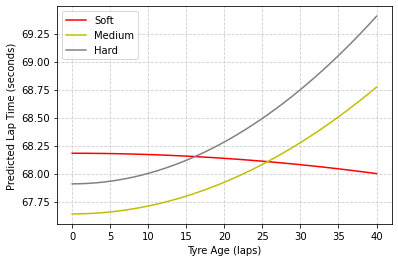

In [19]:
plot_tyre_deg_curves(num_laps_plot = 40, qual_time_plot = 64.2, remove_fuel_effect = True, model = model_quadratic)

We can also plot the actual vs expected lap times for each driver, given the tyres they used and the laps that they pitted.

In [20]:
def plot_driver_laps_actual_vs_expected(driver_name, max_laps_to_plot, model, omega = 2):
    '''
    :param driver_name: String, the name of the driver for which to plot their lap times
    :param max_laps_to_plot: Integer, the number of laps to plot
    :param model: Linear regression model object that has been fitted
    :param omega: Positive float at least 1; the power of tyre age to fit in the model
    '''
    
    # Plot the actual lap times
    d = driver_name
    driver_df = results_df[(results_df['driver_name'] == d) & (results_df['lap_number'] <= max_laps_to_plot)]
    fig, ax = plt.subplots()
    axis_raw = driver_df.sort_values(by=['lap_number'])
    tyres = axis_raw['tyre_description']
    colours = []
    for t in tyres:
        if t == 'Soft':
            colour = 'r'
        elif t == 'Medium':
            colour = 'y'
        elif t == 'Hard':
            colour = '0.5'
        elif t == 'Inter':
            colour = 'g'
        elif t == 'Wet':
            colour = 'b'
        else:
            colour = 'k'
        colours.append(colour)
    tyre_status = axis_raw['tyre_status']
    line_style = []
    for t in tyre_status:
        if t == 'New':
            line = '-'
        elif t == 'Used':
            line = '--'
        else:
            line = ':'
        line_style.append(line)
    axis_raw['colour_scheme'] = colours
    axis_raw['line_style'] = line_style
    axis_raw_grouped = axis_raw.groupby(['tyre_stint_number','tyre_description','tyre_status','colour_scheme',
                                         'line_style']).size().reset_index()
    for index, row in axis_raw_grouped.iterrows():
        stint = row['tyre_stint_number']
        colour_plot = row['colour_scheme']
        line_plot = row['line_style']
        tyre_description = row['tyre_description']
        tyre_status = row['tyre_status']
        label_str = tyre_status + ' ' + tyre_description
        axis_raw_filtered = axis_raw[axis_raw['tyre_stint_number'] == stint].sort_values(by=['lap_number'])
        x_axis = axis_raw_filtered['lap_number']
        y_axis = axis_raw_filtered['lap_time']
        ax.plot(x_axis, y_axis, label = label_str,
                linestyle = line_plot,
                color = colour_plot)
    plt.title('Actual & Predicted Lap Times for {0}'.format(d))
    plt.xlabel("Lap Number")
    plt.ylabel("Lap Time (seconds)")
    plt.legend()
    plt.minorticks_on()
    plt.grid(which = 'major', linestyle = ':', linewidth = '0.5', color = '0.7')
    plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = '0.85')
    
    
    # Plot the expected lap times
    msk_driver = (drivers == d) & (lap_numbers <= max_laps_to_plot)
    
    is_soft_plot = 1*(tyre_descriptions == 'Soft')[msk_driver]
    t_1_plot = tyre_ages[msk_driver] * is_soft_plot
    is_medium_plot = 1*(tyre_descriptions == 'Medium')[msk_driver]
    t_2_plot = tyre_ages[msk_driver] * is_medium_plot
    is_hard_plot = 1*(tyre_descriptions == 'Hard')[msk_driver]
    t_3_plot = tyre_ages[msk_driver] * is_hard_plot
    laps_plot = lap_numbers[msk_driver]
    n_plot = (max(lap_numbers) - lap_numbers)[msk_driver]
    q_plot = qualifying_times[msk_driver]
    p_in_plot = (1*(pitstops_in >= 1))[msk_driver]
    p_out_plot = (1*(pitstops_out >= 1))[msk_driver]
    
    sort_indices = np.argsort(laps_plot)
    is_soft_plot = np.take_along_axis(is_soft_plot, sort_indices, axis = 0)
    t_1_plot = np.take_along_axis(t_1_plot, sort_indices, axis = 0)
    is_medium_plot = np.take_along_axis(is_medium_plot, sort_indices, axis = 0)
    t_2_plot = np.take_along_axis(t_2_plot, sort_indices, axis = 0)
    is_hard_plot = np.take_along_axis(is_hard_plot, sort_indices, axis = 0)
    t_3_plot = np.take_along_axis(t_3_plot, sort_indices, axis = 0)
    laps_plot = np.take_along_axis(laps_plot, sort_indices, axis = 0)
    n_plot = np.take_along_axis(n_plot, sort_indices, axis = 0)
    q_plot = np.take_along_axis(q_plot, sort_indices, axis = 0)
    p_in_plot = np.take_along_axis(p_in_plot, sort_indices, axis = 0)
    p_out_plot = np.take_along_axis(p_out_plot, sort_indices, axis = 0)
    
    # Plot the forecasted lap times
    plot_X = np.c_[t_1_plot**omega, t_2_plot**omega, is_medium_plot, t_3_plot**omega,
                   is_hard_plot, n_plot, q_plot, p_in_plot, p_out_plot]
    plot_y = model.predict(plot_X)

    plt.plot(laps_plot, plot_y, color = 'k', linestyle = ':');
    plt.show()

In the charts below, the dotted black line represents the expected lap time from our model, whilst the lines in the legend represent the actual lap times.

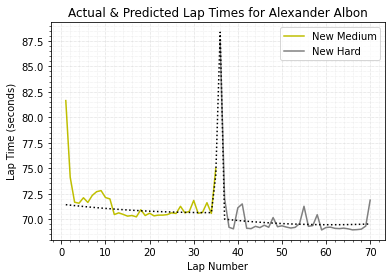

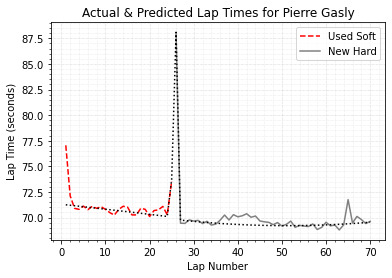

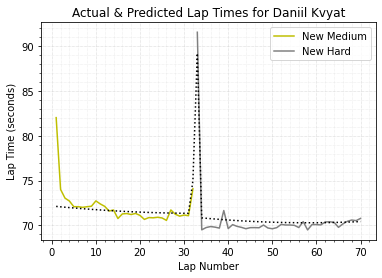

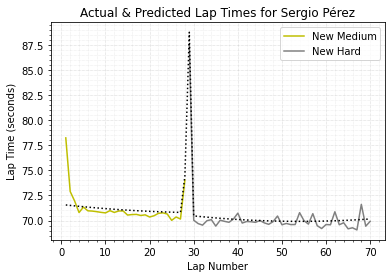

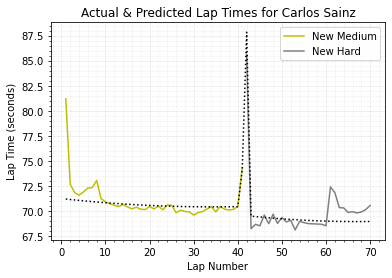

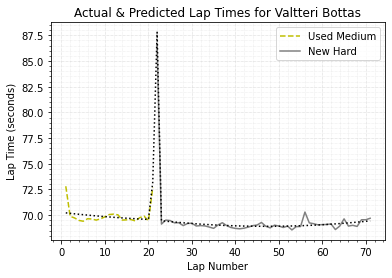

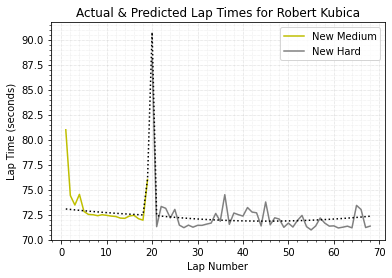

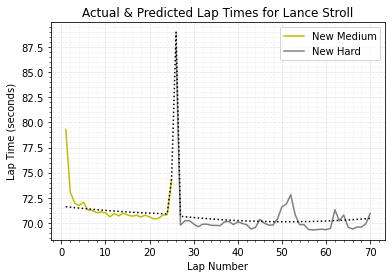

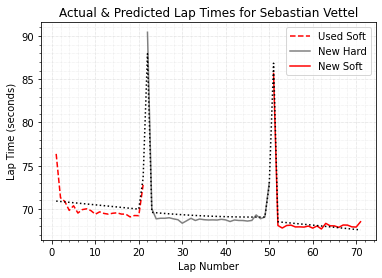

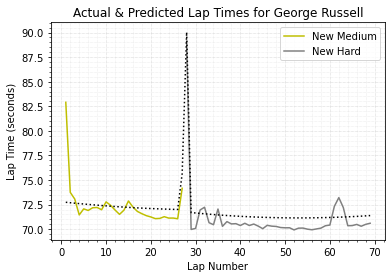

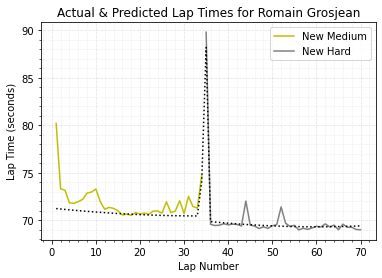

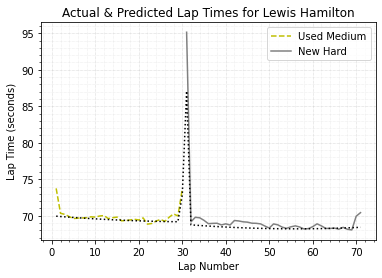

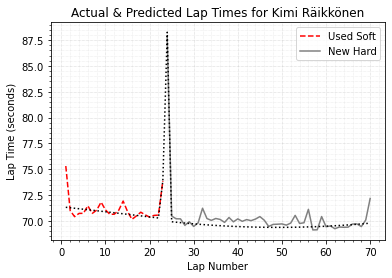

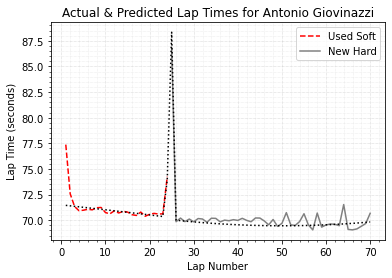

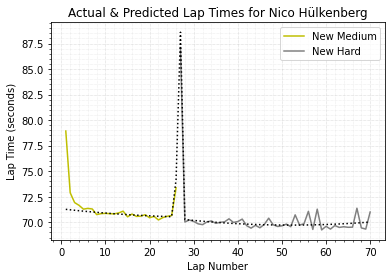

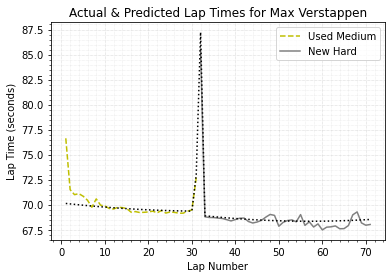

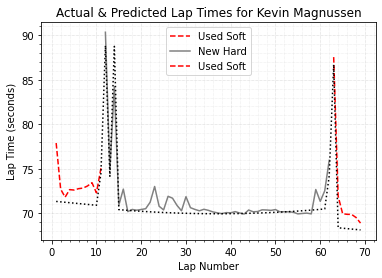

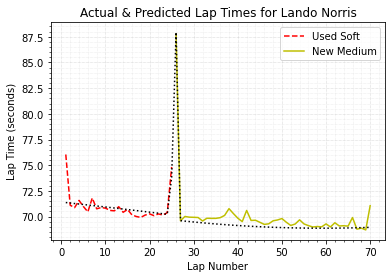

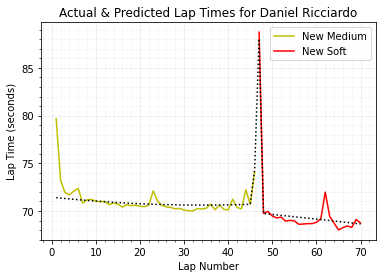

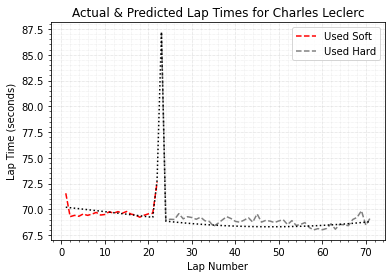

In [22]:
for d in drivers_unique:
    plot_driver_laps_actual_vs_expected(d, 71, model_quadratic)

## 7. Generalising the tyre deg curve: can we improve the model?

With reference to the definitions set out in section (2.), we will now amend our model to cover a family of possible models $M_\omega$, indexed by the hyperparameter $\omega$:

$$l = \sum_{i=1}^{i=3} (\alpha_i t_i^\omega + \beta_i)1_{i} + \gamma n + \delta q + \zeta_{in} p_{in} + \zeta_{out} p_{out} + \epsilon \,$$

$$(\omega >= 1)$$

Previously we were fitting the $M_2$ model ($\omega = 2$) - we will now perform a grid search across different values of $\omega$ to find which one fits the race data best. 10-fold cross validation will be used here to help identify the models which fit best across many training/test dataset combinations.

In [23]:
from sklearn.model_selection import cross_validate

def fit_omega_model(omega = 2):
    y = results_df['lap_time'].to_numpy()[msk]
    X = np.c_[t_1**omega, t_2**omega, is_medium, t_3**omega, is_hard, n, q, p_in, p_out]
    model_omega = LinearRegression(fit_intercept = False)
    scores = cross_validate(model_omega, X, y, cv = 10)['test_score'] # 10-fold cross-validation
    return [scores.mean(), model_omega.fit(X,y)]

We now define the grid of values of omega to search over.

In [24]:
omega_grid = np.linspace(1,4,121)
print(omega_grid)

[1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275
 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475 1.5   1.525 1.55  1.575
 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775 1.8   1.825 1.85  1.875
 1.9   1.925 1.95  1.975 2.    2.025 2.05  2.075 2.1   2.125 2.15  2.175
 2.2   2.225 2.25  2.275 2.3   2.325 2.35  2.375 2.4   2.425 2.45  2.475
 2.5   2.525 2.55  2.575 2.6   2.625 2.65  2.675 2.7   2.725 2.75  2.775
 2.8   2.825 2.85  2.875 2.9   2.925 2.95  2.975 3.    3.025 3.05  3.075
 3.1   3.125 3.15  3.175 3.2   3.225 3.25  3.275 3.3   3.325 3.35  3.375
 3.4   3.425 3.45  3.475 3.5   3.525 3.55  3.575 3.6   3.625 3.65  3.675
 3.7   3.725 3.75  3.775 3.8   3.825 3.85  3.875 3.9   3.925 3.95  3.975
 4.   ]


In [25]:
scores_grid = []
models_grid = []
for omega in omega_grid:
    scores_grid.append(fit_omega_model(omega)[0])
    models_grid.append(fit_omega_model(omega)[1])
m = max(scores_grid)
m = [i for i, j in enumerate(scores_grid) if j == m][0]
omega_optimal = omega_grid[m]
print('The optimal value of omega is {:.4g}, producing an R^2 score of {:.4g}'
      .format(omega_optimal, scores_grid[m]))
model_omega_optimal = models_grid[m]

The optimal value of omega is 2.925, producing an R^2 score of 0.9146


Finally, we visualise the results of using this optimal value of $\omega$.

In [26]:
print('Let t be the age of a tyre')
print('The soft tyre degrades as {:.4g}*t^{:.4g}'.format(model_omega_optimal.coef_[0], omega_optimal))
print('The medium tyre degrades as {:.4g}*t^{:.4g} and is {:.4g} secs/lap slower than the soft tyre excl deg'.format(model_omega_optimal.coef_[1], omega_optimal, model_omega_optimal.coef_[2]))
print('The hard tyre degrades as {:.4g}*t^{:.4g} and is {:.4g} secs/lap slower than the soft tyre excl deg'.format(model_omega_optimal.coef_[3], omega_optimal, model_omega_optimal.coef_[4]))
print('Each lap of fuel is worth {:.4g} seconds of lap time'.format(model_omega_optimal.coef_[5]))
print('Race laps are around {:.4g}% slower than qualifying laps'.format(model_omega_optimal.coef_[6]*100 - 100))
print('An in-lap to the pits costs {:.4g} seconds of lap time'.format(model_omega_optimal.coef_[7]))
print('An out-lap from the pits costs {:.4g} seconds of lap time'.format(model_omega_optimal.coef_[8]))
print('The total time loss from a pitstop is {:.4g} seconds'.format(model_omega_optimal.coef_[7] + model_omega_optimal.coef_[8]))

Let t be the age of a tyre
The soft tyre degrades as -3.089e-06*t^2.925
The medium tyre degrades as 2.345e-05*t^2.925 and is -0.4398 secs/lap slower than the soft tyre excl deg
The hard tyre degrades as 2.704e-05*t^2.925 and is -0.1584 secs/lap slower than the soft tyre excl deg
Each lap of fuel is worth 0.04494 seconds of lap time
Race laps are around 6.334% slower than qualifying laps
An in-lap to the pits costs 3.641 seconds of lap time
An out-lap from the pits costs 18.19 seconds of lap time
The total time loss from a pitstop is 21.83 seconds


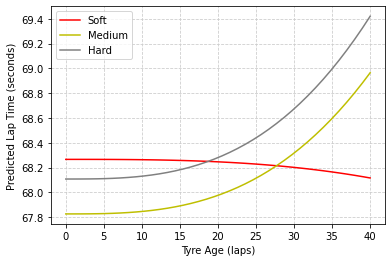

In [27]:
plot_tyre_deg_curves(num_laps_plot = 40, qual_time_plot = 64.2, remove_fuel_effect = True,
                     model = model_omega_optimal, omega = omega_optimal)

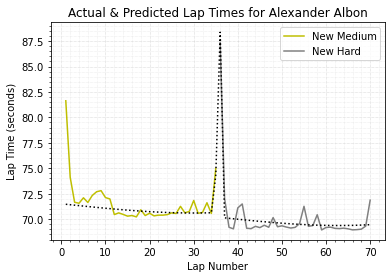

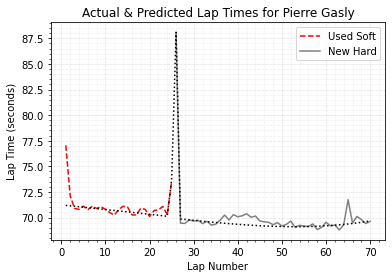

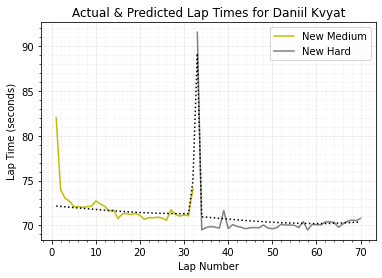

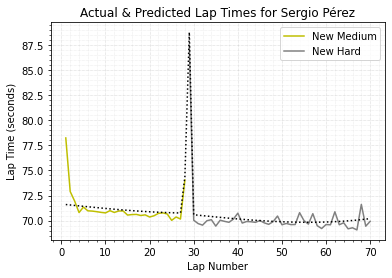

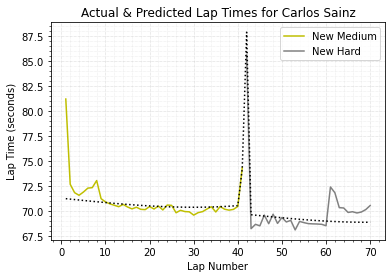

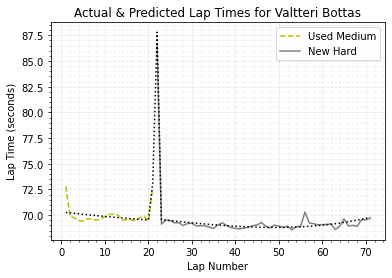

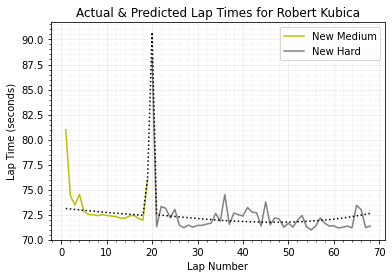

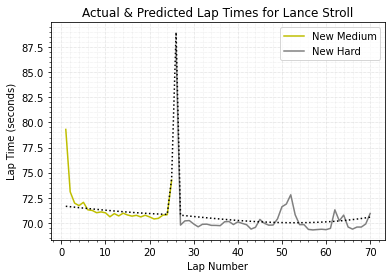

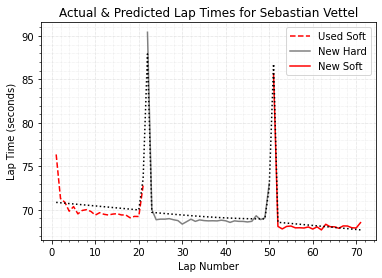

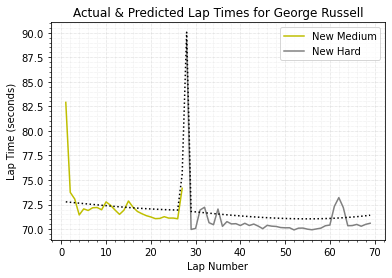

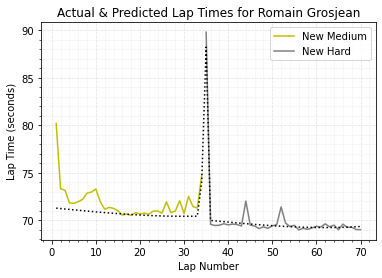

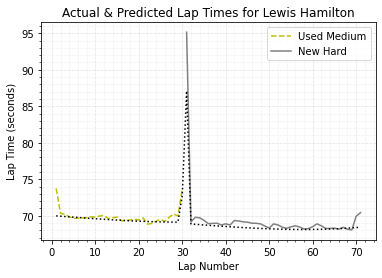

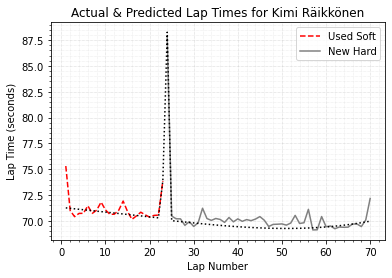

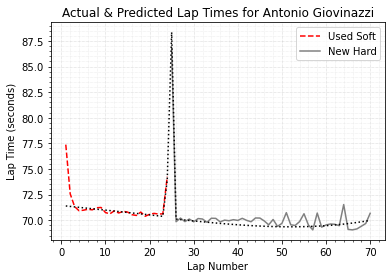

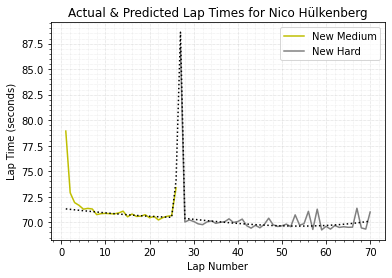

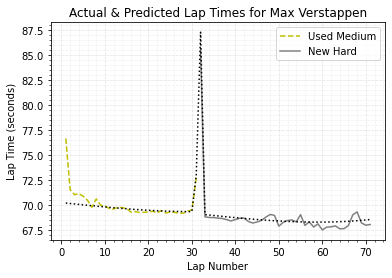

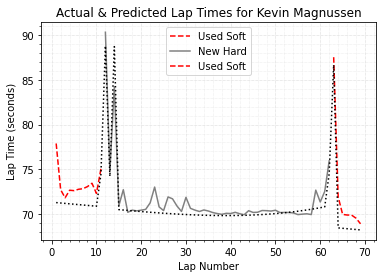

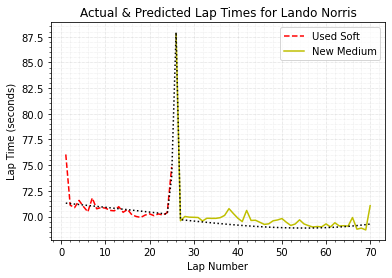

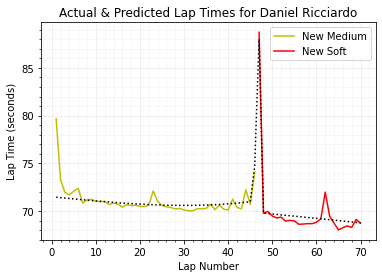

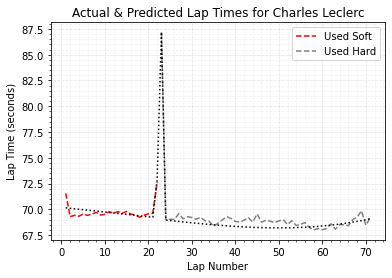

In [28]:
for d in drivers_unique:
    plot_driver_laps_actual_vs_expected(d, 71, model_omega_optimal, omega = omega_optimal)

## 8. Conclusion: What worked well? What should a better model do?

For fuel effect and pit stop time loss, the model appears to perform well, with the resulting estimates looking intuitively correct and agreeing with ball-park figures observed from the Grand Prix itself. It's interesting to also see the Haas driver Kevin Magnussen consistently underperforming against model expectations - this makes a lot of sense, as the Haas car really struggled a lot more on race days vs their qualifying performance in 2019. As our model takes the qualifying time as a measure of raw pace, this is why the model expects a faster race pace for Kevin.

For the tyre deg part of the model, there are challenges in capturing the most important factors affecting it. For example, we don't take into account track temperature, or whether a driver is running in dirty air directly behind another car (which normally accelerates tyre wear), or whether a driver starts off their stint conservatively to preserve tyre life. This in part is a challenge that comes from working with the actual race data itself - if we were to use times from a testing or practice session, the team could put together a schedule that would allow as much as possible for like-for-like comparisons between different tyre compounds.

A better model would also try to capture the effect of drivers trying to drive conservatively and extend the tyre life, which appears to be what threw off the soft tyre model vs what we would expect. This also impacts the raw lap 1 performance of the tyre compounds, with the model currently telling us that the medium tyre starts off faster than the soft tyre - most likely this is due to the difference in how these tyres are pushed on their first laps in the race.

Ideally, we would arrange to have lap time data from a test session, where:
* each tyre compound is tried over a 40 lap stint (for example)
* all tyres are pushed to the same extent by the driver (i.e. no changes to driving style which could otherwise alter the tyre deg curve vs the other compounds)
* each stint is ran at a similar time of day with similar track temperature

This would give us some really insightful data that would likely allow the model to fit more accurately - particularly when it comes to tyre degradation.